## Prepare Dataset

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
print(tf.__version__)

2.4.1


In [ ]:
! pip install -q kaggle

In [ ]:
# upload your token from kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fandisyamsudin","key":"15263541ec7ec2cd7938990ceda27c01"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d piaoya/plastic-recycling-codes
!unzip plastic-recycling-codes

plastic-recycling-codes.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  plastic-recycling-codes.zip
  inflating: seven_plastics/1_polyethylene_PET/85943598-ec9b-4da5-9221-8c32b5742e72.jpg  
  inflating: seven_plastics/1_polyethylene_PET/AORA7148.jpg  
  inflating: seven_plastics/1_polyethylene_PET/BBOZ2526.jpg  
  inflating: seven_plastics/1_polyethylene_PET/BIGI9753.jpg  
  inflating: seven_plastics/1_polyethylene_PET/FQCK7421.jpg  
  inflating: seven_plastics/1_polyethylene_PET/HSBT4561.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6263.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6268.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6269.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6271.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6272.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6308.jpg  
  inflating: seven_plastics/1_polyethylene_PET/IMG_6328.jpg  
  inflating: seve

In [40]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_DIR = ('H:/datasets/seven_plastics')

## PreProcessing Dataset

In [41]:
train_dataset = image_dataset_from_directory(
    IMG_DIR,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed = 21
)

Found 606 files belonging to 7 classes.
Using 485 files for training.


In [42]:
validation_dataset = image_dataset_from_directory(
    IMG_DIR,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed = 21
)

Found 606 files belonging to 7 classes.
Using 121 files for validation.


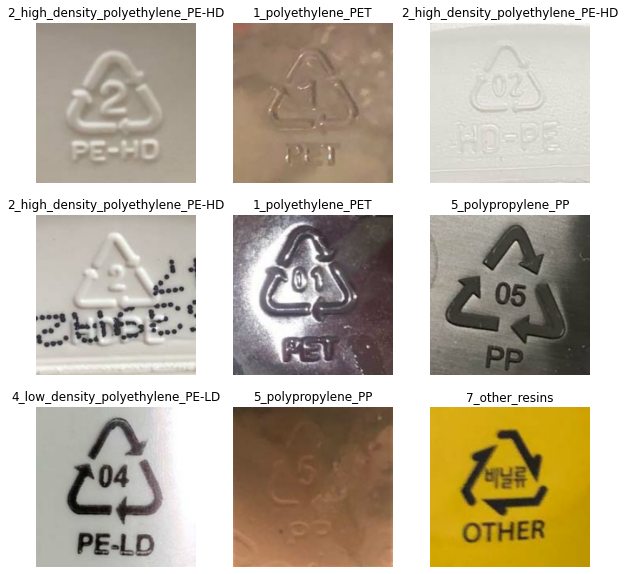

In [43]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, 1+i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [44]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
])


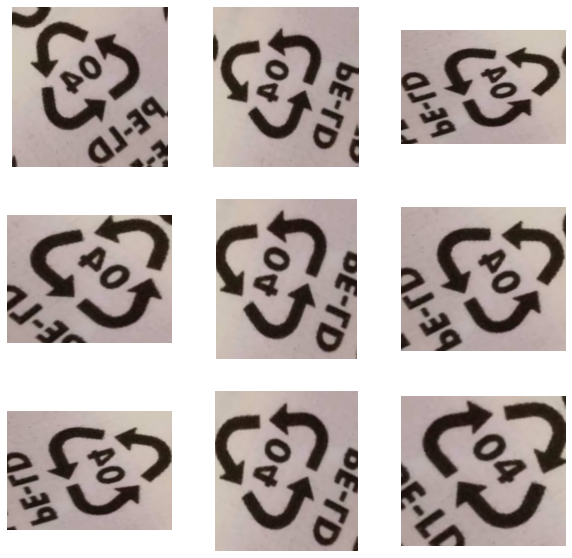

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [46]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Build Model

In [47]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                            include_top=False,
                                            weights='imagenet')

In [48]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [49]:
base_model.trainable = False

In [50]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [51]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [52]:
num_classes = len(class_names)
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 7)


In [53]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_____________________________________________

In [55]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_____________________________________________

In [57]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)


4/4 [==============================] - 2s 56ms/step - loss: 2.1619 - accuracy: 0.1663


## Training Model

In [58]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/5
16/16 [==============================] - 5s 120ms/step - loss: 2.1423 - accuracy: 0.2165 - val_loss: 1.9840 - val_accuracy: 0.2479
Epoch 2/5
16/16 [==============================] - 2s 114ms/step - loss: 2.0461 - accuracy: 0.2660 - val_loss: 1.9375 - val_accuracy: 0.2645
Epoch 3/5
16/16 [==============================] - 2s 97ms/step - loss: 1.9939 - accuracy: 0.2763 - val_loss: 1.9049 - val_accuracy: 0.2562
Epoch 4/5
16/16 [==============================] - 2s 83ms/step - loss: 1.9588 - accuracy: 0.2763 - val_loss: 1.8852 - val_accuracy: 0.2562
Epoch 5/5
16/16 [==============================] - 2s 85ms/step - loss: 1.9253 - accuracy: 0.2619 - val_loss: 1.8469 - val_accuracy: 0.2727


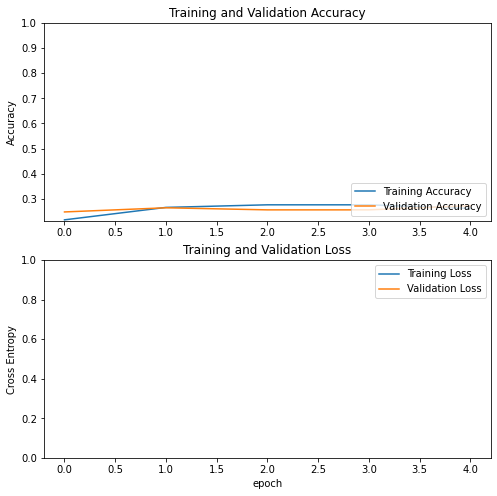

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine Tune Model

In [60]:
base_model.trainable = True

In [61]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [62]:
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [63]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 2,183,559
Non-trainable params: 83,392
____________________________________________

In [65]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/25
16/16 [==============================] - 10s 253ms/step - loss: 1.8840 - accuracy: 0.2836 - val_loss: 1.7436 - val_accuracy: 0.2727
Epoch 6/25
16/16 [==============================] - 3s 157ms/step - loss: 1.7434 - accuracy: 0.3015 - val_loss: 1.6888 - val_accuracy: 0.3388
Epoch 7/25
16/16 [==============================] - 3s 136ms/step - loss: 1.7652 - accuracy: 0.2888 - val_loss: 1.6813 - val_accuracy: 0.3223
Epoch 8/25
16/16 [==============================] - 3s 148ms/step - loss: 1.6782 - accuracy: 0.3208 - val_loss: 1.7197 - val_accuracy: 0.2975
Epoch 9/25
16/16 [==============================] - 3s 147ms/step - loss: 1.6723 - accuracy: 0.3358 - val_loss: 1.6734 - val_accuracy: 0.3306
Epoch 10/25
16/16 [==============================] - 3s 141ms/step - loss: 1.5984 - accuracy: 0.3548 - val_loss: 1.6621 - val_accuracy: 0.3223
Epoch 11/25
16/16 [==============================] - 3s 144ms/step - loss: 1.6063 - accuracy: 0.3922 - val_loss: 1.7481 - val_accuracy: 0.2645
Epo

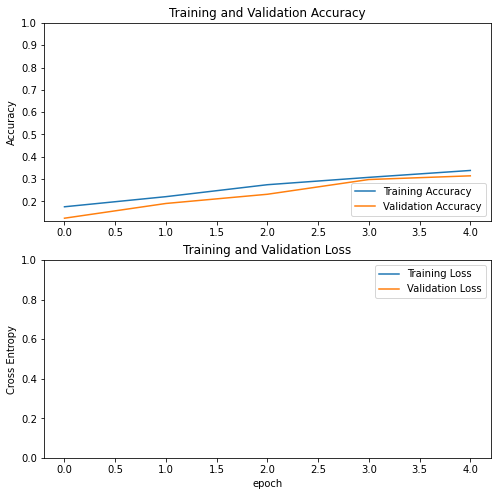

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [66]:
total_epochs =  120

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/120
16/16 [==============================] - 2s 122ms/step - loss: 1.4347 - accuracy: 0.4289 - val_loss: 1.6120 - val_accuracy: 0.3636
Epoch 6/120
16/16 [==============================] - 2s 104ms/step - loss: 1.4055 - accuracy: 0.4722 - val_loss: 1.6061 - val_accuracy: 0.3884
Epoch 7/120
16/16 [==============================] - 2s 110ms/step - loss: 1.4083 - accuracy: 0.4515 - val_loss: 1.6286 - val_accuracy: 0.3884
Epoch 8/120
16/16 [==============================] - 2s 107ms/step - loss: 1.4160 - accuracy: 0.4515 - val_loss: 1.6821 - val_accuracy: 0.3802
Epoch 9/120
16/16 [==============================] - 2s 116ms/step - loss: 1.4107 - accuracy: 0.4433 - val_loss: 1.5791 - val_accuracy: 0.3802
Epoch 10/120
16/16 [==============================] - 2s 107ms/step - loss: 1.3765 - accuracy: 0.4268 - val_loss: 1.5827 - val_accuracy: 0.3554
Epoch 11/120
16/16 [==============================] - 2s 121ms/step - loss: 1.4039 - accuracy: 0.4557 - val_loss: 1.5573 - val_accuracy: 0.37

Epoch 62/120
16/16 [==============================] - 2s 111ms/step - loss: 0.9901 - accuracy: 0.6351 - val_loss: 1.6343 - val_accuracy: 0.4215
Epoch 63/120
16/16 [==============================] - 2s 120ms/step - loss: 0.9766 - accuracy: 0.6412 - val_loss: 1.6616 - val_accuracy: 0.4050
Epoch 64/120
16/16 [==============================] - 2s 108ms/step - loss: 1.0593 - accuracy: 0.5918 - val_loss: 1.7575 - val_accuracy: 0.3802
Epoch 65/120
16/16 [==============================] - 2s 102ms/step - loss: 0.9902 - accuracy: 0.6392 - val_loss: 1.7822 - val_accuracy: 0.3471
Epoch 66/120
16/16 [==============================] - 2s 108ms/step - loss: 1.0173 - accuracy: 0.6247 - val_loss: 1.9376 - val_accuracy: 0.3388
Epoch 67/120
16/16 [==============================] - 2s 108ms/step - loss: 0.9710 - accuracy: 0.6330 - val_loss: 1.6487 - val_accuracy: 0.3802
Epoch 68/120
16/16 [==============================] - 2s 117ms/step - loss: 1.0159 - accuracy: 0.6227 - val_loss: 1.8238 - val_accuracy:

Epoch 119/120
16/16 [==============================] - 2s 103ms/step - loss: 0.6465 - accuracy: 0.7897 - val_loss: 1.7813 - val_accuracy: 0.3967
Epoch 120/120
16/16 [==============================] - 2s 110ms/step - loss: 0.7407 - accuracy: 0.7216 - val_loss: 1.7414 - val_accuracy: 0.4050


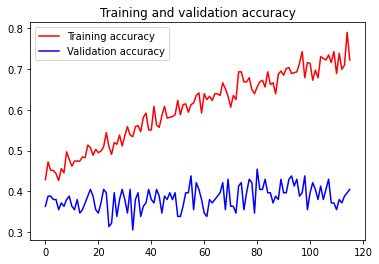

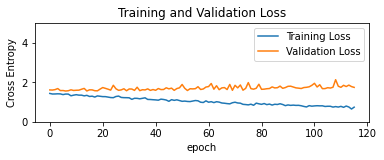

In [67]:
# display the curves

acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')



plt.show()

## Evaluate Model

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 64ms/step - loss: 1.5029 - accuracy: 0.7299
Test accuracy : 0.7299270033836365


## Save Model

In [ ]:
model.save('fandi-efficientnet-model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fandi-efficientnet-model/assets


## Convert to Json

In [ ]:
# convert to json
import json
json_string = model.to_json()
f = open("../content/fandi-efficientnet-model.json", "w")
json.dump(json_string, f)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('fandi-efficientnet-model.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpfm5c65cn/assets


In [ ]:
# create labels 
labels = '\n'.join(sorted(train_dataset.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)

## Save to Bucket on GCP

In [ ]:
# Authentic Colab 
# (running this will give you a code to authentic your Google Colab instance, keep the code secret)
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install and initialize the gcloud command line tool - https://cloud.google.com/sdk/docs/install
# (this will give you access to gcloud tools within Colab)
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0  19260      0 --:--:-- --:--:-- --:--:-- 19260
######################################################################## 100.0%
which curl
curl -# -f https://dl.google.com/dl/cloudsdk/channels/rapid/google-cloud-sdk.tar.gz
######################################################################## 100.0%
mkdir -p /root
tar -C /root -zxvf /tmp/tmp.19tU99QGCL/google-cloud-sdk.tar.gz
/root/google-cloud-sdk/install.sh
Beginning update. This process may take several minutes.


Your current Cloud SDK version is: 342.0.0
Installing components from version: 342.0.0

┌─────────────────────────────────────────────────────────────────────────────┐
│                     These components will be installed.                     │
├─────────────────────────────────────────────────────┬────────────┬──────────┤
│        

In [ ]:
# Copy model to bucket - https://cloud.google.com/storage/docs/uploading-objects#gsutil 
# Use "-r" for folders (r stands for recursive)
!gsutil cp -r fandi-efficientnet-model gs://go-bin-capstone

Copying file://fandi-efficientnet-model/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://fandi-efficientnet-model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://fandi-efficientnet-model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://fandi-efficientnet-model/variables/variables.index [Content-Type=application/octet-stream]...
/ [4 files][ 39.1 MiB/ 39.1 MiB]                                                
Operation completed over 4 objects/39.1 MiB.                                     


## The End